# Datathon

In [1]:
# Libraries to be used in the model
import pandas as pd
import numpy as np
import seaborn as sn
import re 

# Ploting libraries
import matplotlib.pyplot as plt

# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor

# Metrics or statistics to use
from statistics import mean
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error,confusion_matrix,classification_report

######################################

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import sklearn
sklearn.set_config(display='diagram')

C:\Users\Mario Jesus\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Get unique values per column
def print_unique_values_per_column(d):
    for c in d.columns:
        if (d[c].nunique() < 30):
            print(c, d[c].nunique(), d[c].dtype, d[c].unique())
        else:
            print(c, d[c].nunique(), d[c].dtype)

# Print missing values
def print_missing_values(d):
    missing_total = d.isnull().sum().sort_values(ascending=False)
    missing_percent = (d.isnull().sum()/d.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([missing_total, missing_percent], axis=1, keys=['Total', 'Percent'])
    missing = missing[missing['Percent'] > 0]
    print(missing)

def get_columns_with_nulls(d):
    missing_total = d.isnull().sum().sort_values(ascending=False)
    missing_percent = (d.isnull().sum()/d.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([missing_total, missing_percent], axis=1, keys=['Total', 'Percent'])
    missing = missing[missing['Percent'] > 0]
    return missing.index.values

# Custom accuracy evaluation
def accuracy_score(estimator, X, y):
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    accuracy = mean(1 - mean_absolute_error(y, y_pred)/y_pred)
    return accuracy

## Import Datasets

In [3]:
train = pd.read_csv('train_data.csv', parse_dates=['ofd_date'], dayfirst=True)
train.shape

(11309, 13)

In [4]:
test = pd.read_csv('test.csv', index_col='Unnamed: 0', parse_dates=['ofd_date'], dayfirst=True)
test.shape

(2389, 11)

In [5]:
train.shape

(11309, 13)

In [6]:
train.dtypes

ofd_date        datetime64[ns]
country_code            object
fc_codes                object
station_code            object
OFD                      int64
Slam                     int64
Earlies_Exp              int64
Earlies_Rec              int64
MNR_SNR_Exp              int64
Rollover                 int64
Returns                  int64
R_Sideline               int64
Sideline                 int64
dtype: object

In [7]:
train.isnull().sum()

ofd_date        0
country_code    0
fc_codes        0
station_code    0
OFD             0
Slam            0
Earlies_Exp     0
Earlies_Rec     0
MNR_SNR_Exp     0
Rollover        0
Returns         0
R_Sideline      0
Sideline        0
dtype: int64

In [8]:
train.describe().round(0)

,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
count,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0
mean,16108.0,16050.0,645.0,653.0,216.0,232.0,162.0,181.0,176.0
std,7391.0,7243.0,605.0,609.0,475.0,603.0,304.0,497.0,485.0
min,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,11298.0,11337.0,220.0,225.0,76.0,51.0,40.0,0.0,0.0
50%,14644.0,14617.0,463.0,475.0,120.0,87.0,81.0,2.0,2.0
75%,19113.0,19120.0,867.0,876.0,208.0,183.0,148.0,115.0,119.0
max,50365.0,50421.0,4934.0,5219.0,17411.0,18839.0,5479.0,8090.0,8121.0


In [9]:
## 1) Create the target column
train["Target"] = train['Earlies_Exp'] - train['MNR_SNR_Exp']
train.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target
0,2021-06-30,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4,167
1,2021-06-30,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1,444
2,2021-06-30,C,"F1, F4, F6, F7, F13, F15, F16",D34,14562,15651,1028,1910,225,35,47,3,1,803
3,2021-06-30,C,"F2, F6, F7, F10, F12, F13, F14, F15, F19",D45,11165,11467,514,769,56,39,29,0,1,458
4,2021-06-30,C,"F6, F8, F13, F14, F17",D50,10006,10423,399,842,52,60,65,1,1,347


## EDA (Exploratory Data Analysis)

In [10]:
pd.DataFrame.set_index(train.loc[:, ['ofd_date', 'Target']], 'ofd_date').describe() #.plot(figsize=(12,4))

,Target
count,11309.000000
mean,428.840481
std,718.831072
min,-16625.000000
25%,88.000000
50%,298.000000
75%,660.000000
max,4878.000000


In [11]:
train.columns

Index(['ofd_date', 'country_code', 'fc_codes', 'station_code', 'OFD', 'Slam',
       'Earlies_Exp', 'Earlies_Rec', 'MNR_SNR_Exp', 'Rollover', 'Returns',
       'R_Sideline', 'Sideline', 'Target'],
      dtype='object')

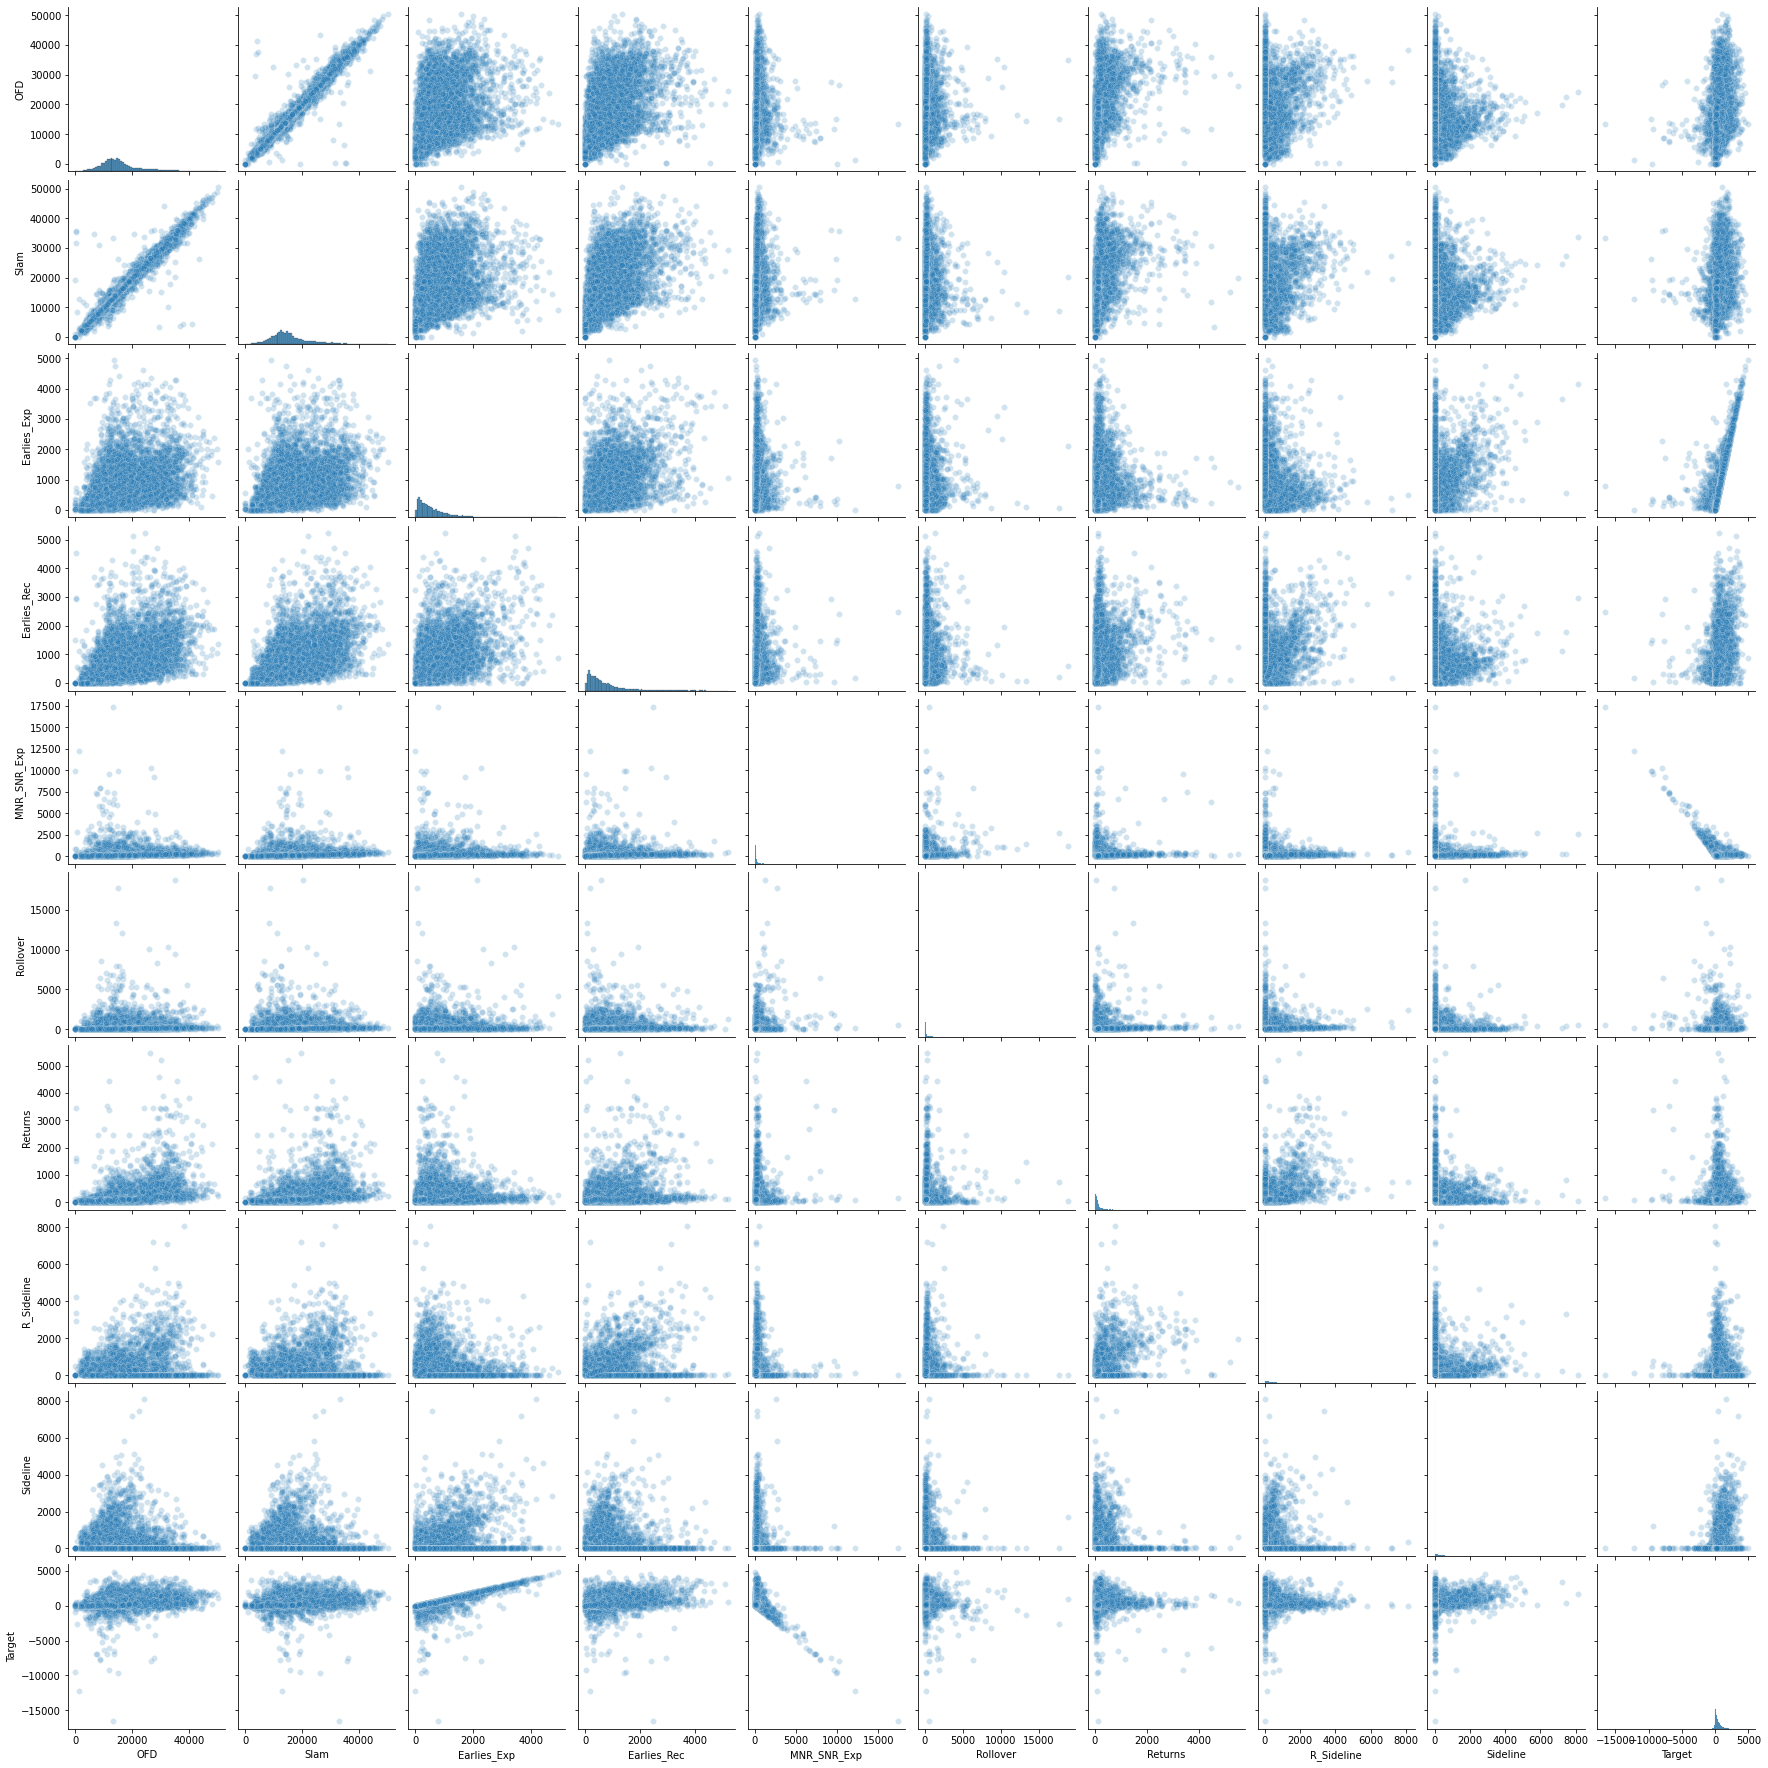

In [12]:
numeric_columns = ['OFD', 'Slam', 'Earlies_Exp', 'Earlies_Rec', 'MNR_SNR_Exp', 'Rollover', 'Returns',
       'R_Sideline', 'Sideline', 'Target']

sn.pairplot(train[numeric_columns],kind="scatter", plot_kws=dict( alpha=0.2))

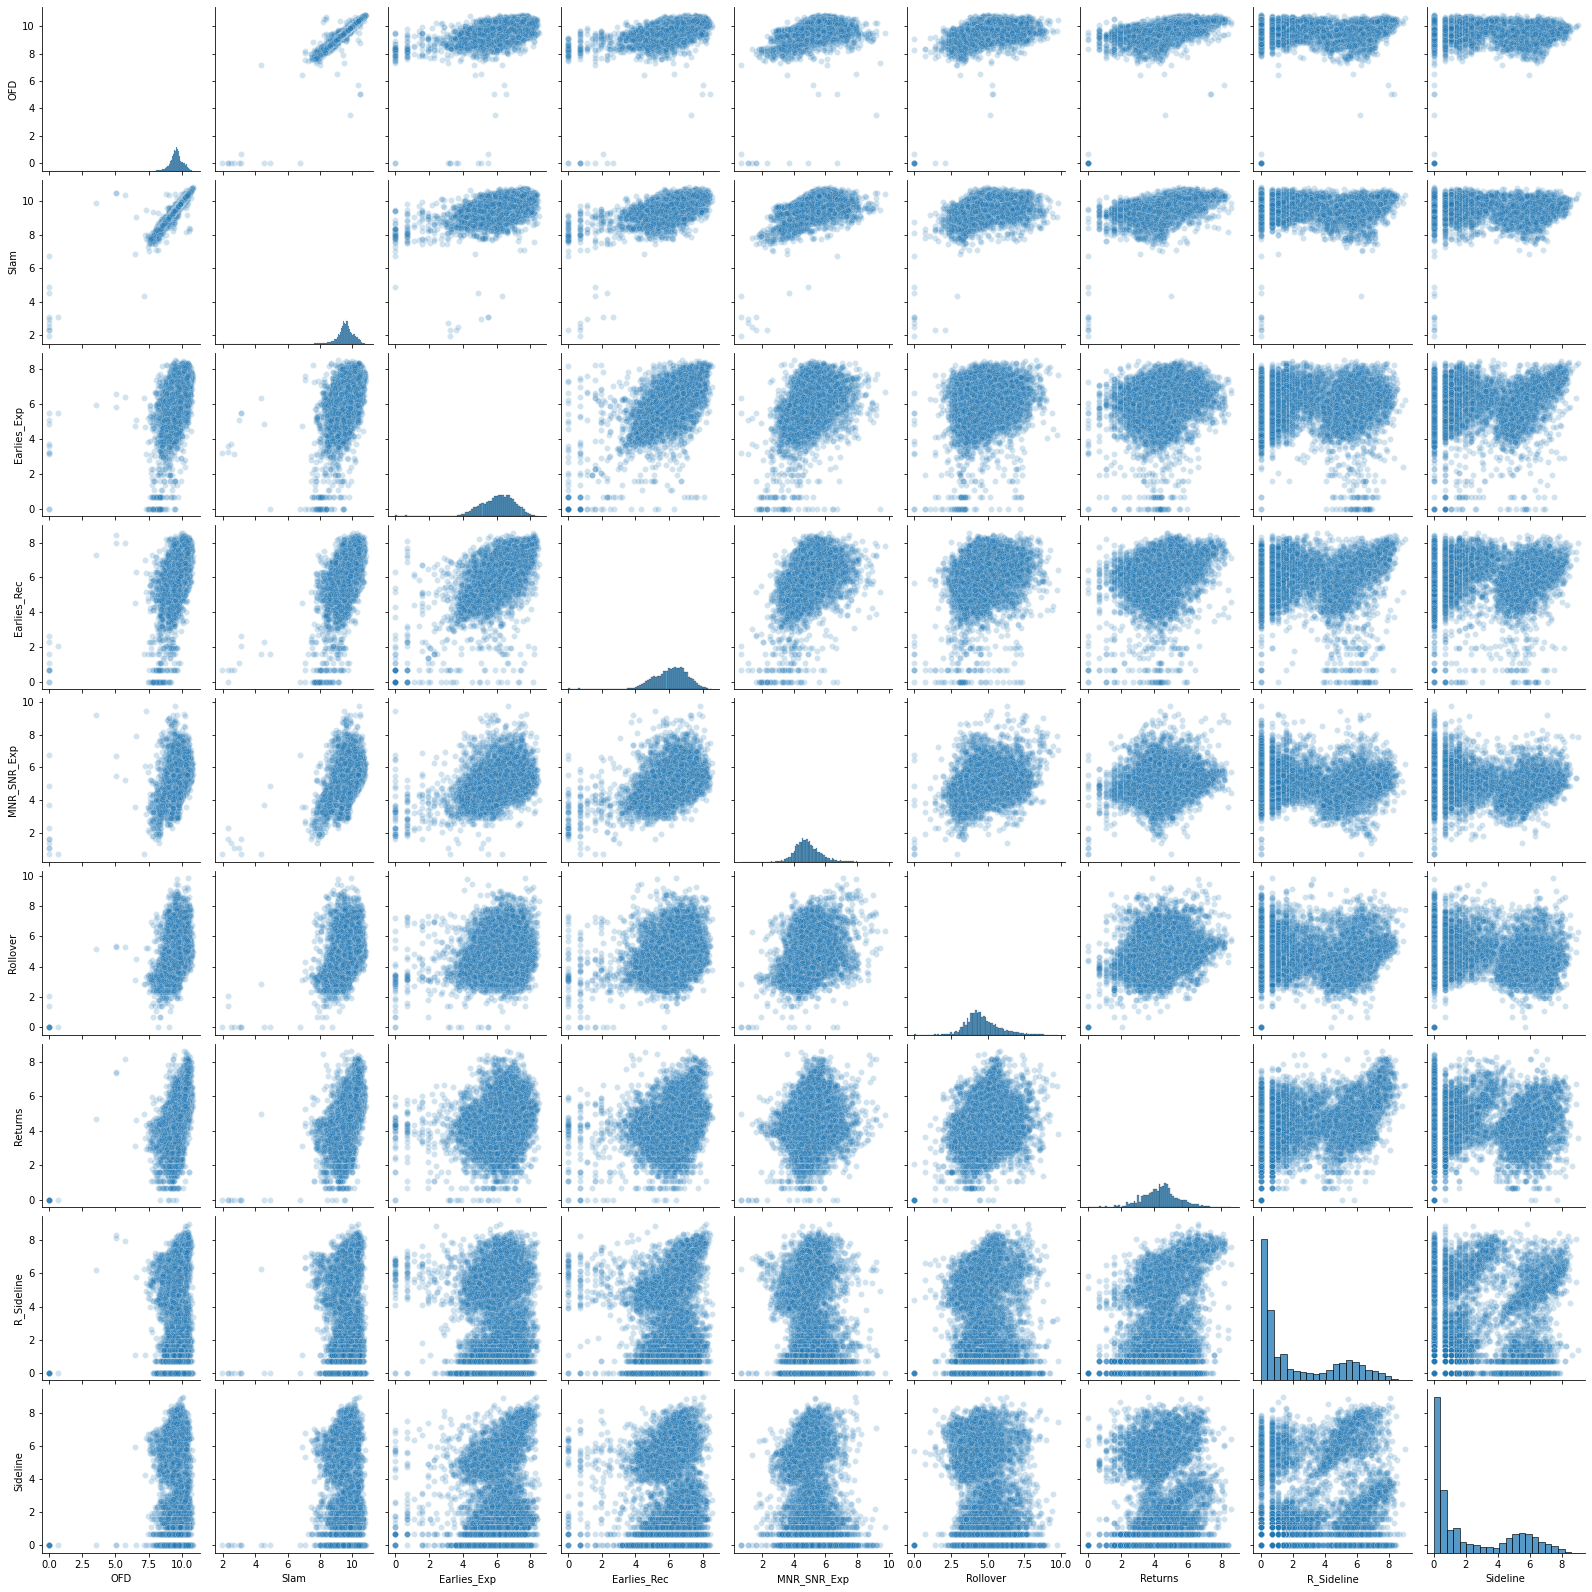

In [13]:
numeric_df = train[numeric_columns[:-1]].copy()
numeric_df = numeric_df.apply(lambda x: np.log(x+1))

sn.pairplot(numeric_df,kind="scatter", plot_kws=dict( alpha=0.2))

In [14]:
rob = RobustScaler()
train_2 = rob.fit_transform(train[numeric_columns])
train_2 = pd.DataFrame(train_2, columns=numeric_columns)
# train_2.describe

In [17]:
for col, ax in zip(numeric_columns, axes):
    print(col)

OFD
Slam
Earlies_Exp
Earlies_Rec
MNR_SNR_Exp
Rollover
Returns
R_Sideline
Sideline
Target


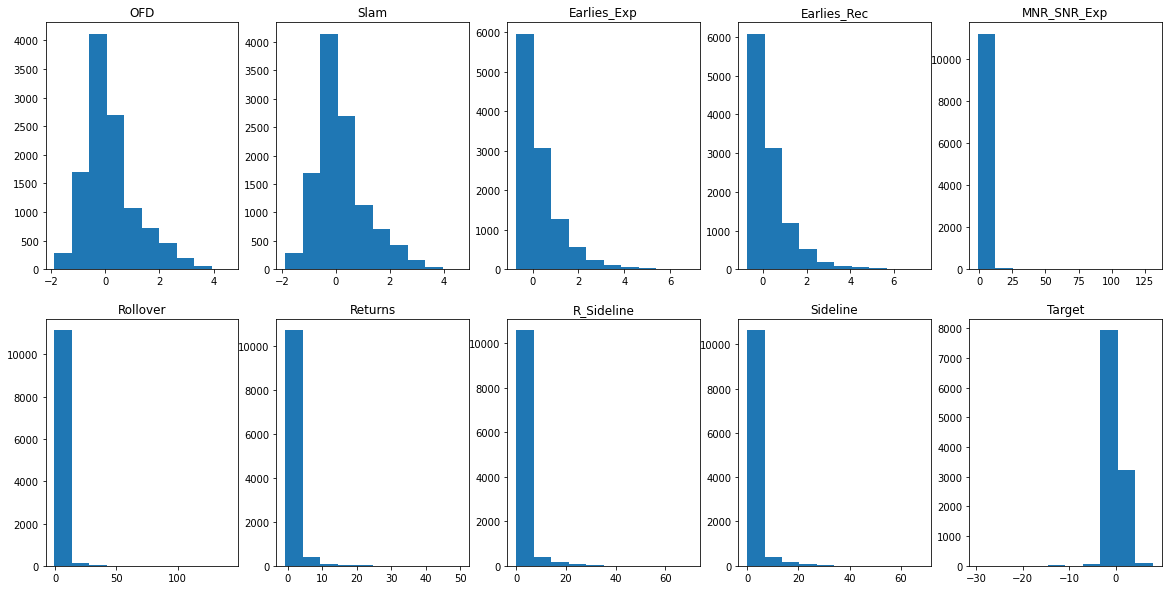

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))

axes = ax.ravel()

for col, ax in zip(numeric_columns, axes):
    if col == 'Target':
        ax.hist(train_2[col])
    else:    
        ax.hist(train_2[col])
    ax.set_title(col)


<AxesSubplot:xlabel='ofd_date'>

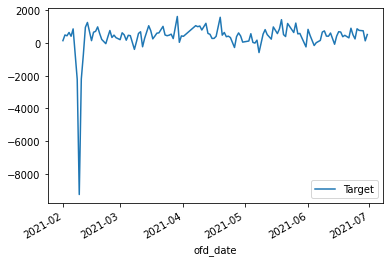

In [16]:
pd.DataFrame.set_index(train.loc[train['station_code'] == 'D35', ['ofd_date', 'Target']], 'ofd_date').groupby('ofd_date').mean().plot()

<AxesSubplot:xlabel='ofd_date'>

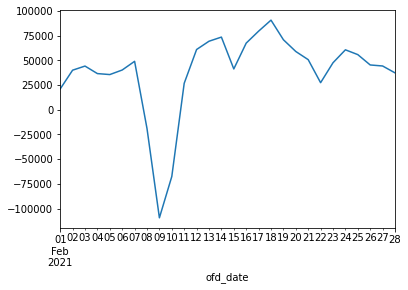

In [18]:
df_train_2 = pd.DataFrame.set_index(train.loc[:, ['ofd_date', 'Target', 'Earlies_Exp', 'MNR_SNR_Exp']], 'ofd_date').groupby('ofd_date').sum()
df_train_2.loc['2021-02-01':'2021-02-28']['Target'].plot()

In [26]:
train.dtypes

ofd_date        datetime64[ns]
country_code            object
fc_codes                object
station_code            object
OFD                      int64
Slam                     int64
Earlies_Exp              int64
Earlies_Rec              int64
MNR_SNR_Exp              int64
Rollover                 int64
Returns                  int64
R_Sideline               int64
Sideline                 int64
Target                   int64
dtype: object

## Data Cleaning and Feature Engineering

In [32]:
# Drop day outlayers
train2= train.copy()
values = ['2021-02-08', '2021-02-09', '2021-02-10']
train2 = train2[train2.ofd_date.isin(values)==False]

In [35]:
train2[(train2['ofd_date'] > '2021-02-07') & (train2['ofd_date'] < '2021-02-1')]
train=train2

In [36]:
## 3) Create the column of days of the week with the following codes
"""
0 = Monday
1 = Tuesday
2 = Wednesday
3 = Thrusday
4 = Friday
5 = Saturday
6 = Sunday
""" 
train["dayOfWeek"] = train['ofd_date'].dt.day_of_week
# train.tail()

<AxesSubplot:xlabel='dayOfWeek'>

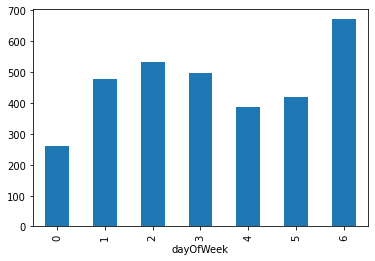

In [37]:
train.groupby('dayOfWeek').mean()['Target'].plot.bar()

In [38]:
new_train = train.iloc[:, 1:]
new_train.head(2)

,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target,dayOfWeek
0,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4,167,2
1,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1,444,2


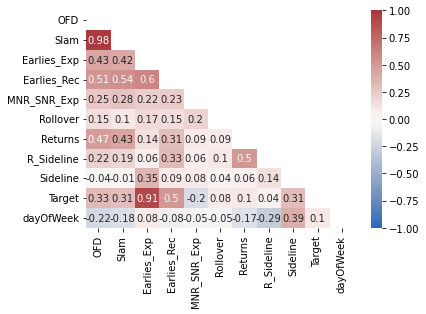

In [39]:
# Checking features correlation

matrix = new_train.corr().round(2)
matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))
sn.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [40]:
new_train['fc_codes'].str.get_dummies(sep=', ').corr()

,F1,F10,F11,F12,F13,F14,F15,F16,F17,F18,...,F51,F52,F53,F54,F55,F56,F6,F7,F8,F9
F1,1.000000,-0.059299,-0.048291,-0.048083,0.776960,-0.099759,0.182551,0.557950,0.138889,-0.033961,...,-0.127484,-0.120026,-0.127484,-0.112318,-0.104292,-0.095856,0.647022,0.430280,0.016137,-0.068981
F10,-0.059299,1.000000,0.393688,0.391994,0.093352,0.378312,0.640169,-0.033086,0.147294,-0.018976,...,-0.071233,-0.067066,-0.071233,-0.062759,-0.058275,-0.053561,0.416664,0.301070,0.147176,0.561095
F11,-0.048291,0.393688,1.000000,-0.021879,-0.062154,0.219340,0.521327,-0.026944,0.202718,-0.015453,...,-0.058010,-0.054616,-0.058010,-0.051109,-0.047456,-0.043618,0.339314,-0.055387,0.453618,0.700063
F12,-0.048083,0.391994,-0.021879,1.000000,0.145068,0.218396,0.519084,-0.026828,-0.048208,-0.015387,...,-0.057760,-0.054381,-0.057760,-0.050889,-0.047252,-0.043430,0.136687,0.395029,-0.048233,-0.031253
F13,0.776960,0.093352,-0.062154,0.145068,1.000000,0.408207,0.221688,0.433505,0.473386,-0.043710,...,-0.164081,-0.154482,-0.164081,-0.144561,-0.134231,-0.123374,0.632414,0.390415,0.371809,-0.088783
F14,-0.099759,0.378312,0.219340,0.218396,0.408207,1.000000,0.203628,-0.055661,0.808555,0.340427,...,-0.119836,-0.112826,-0.119836,-0.105580,-0.098036,-0.090106,0.387820,0.001716,0.808124,0.314110
F15,0.182551,0.640169,0.521327,0.519084,0.221688,0.203628,1.000000,0.408930,0.045595,-0.029642,...,-0.111273,-0.104764,-0.111273,-0.098036,-0.091030,-0.083667,0.540407,0.511728,0.183897,0.543038
F16,0.557950,-0.033086,-0.026944,-0.026828,0.433505,-0.055661,0.408930,1.000000,-0.059367,-0.018948,...,-0.071130,-0.066969,-0.071130,-0.062668,-0.058190,-0.053483,0.416058,0.486466,-0.059398,-0.038488
F17,0.138889,0.147294,0.202718,-0.048208,0.473386,0.808555,0.045595,-0.059367,1.000000,0.319174,...,-0.127816,-0.120339,-0.127816,-0.112610,-0.104563,-0.096106,0.352118,-0.011868,0.754808,0.290327
F18,-0.033961,-0.018976,-0.015453,-0.015387,-0.043710,0.340427,-0.029642,-0.018948,0.319174,1.000000,...,-0.040795,-0.038409,-0.040795,-0.035942,-0.033374,-0.030675,0.238624,-0.038951,0.319009,0.492322


## Initial Data Tranformation 

In [41]:
## Count of FC codes
train.columns

Index(['ofd_date', 'country_code', 'fc_codes', 'station_code', 'OFD', 'Slam',
       'Earlies_Exp', 'Earlies_Rec', 'MNR_SNR_Exp', 'Rollover', 'Returns',
       'R_Sideline', 'Sideline', 'Target', 'dayOfWeek'],
      dtype='object')

In [46]:
# DATA TRANSFORMATION

## 1) Create the target column
train["Target"] = train['Earlies_Exp'] - train['MNR_SNR_Exp']

## 2) Standarized the numerical data (if needed)
for column in ['OFD','Slam','Earlies_Exp','Earlies_Rec','MNR_SNR_Exp','Rollover','Returns','R_Sideline','Sideline']:
    train[column] = (train[column] - train[column].mean()) / train[column].std()
train

## 3) Create the column of days of the week with the following codes
"""
0 = Monday
1 = Tuesday
2 = Wednesday
3 = Thrusday
4 = Friday
5 = Saturday
6 = Sunday
""" 
train["ofd_date"] = pd.to_datetime(train["ofd_date"])
# train["dayOdWeek"] = train['ofd_date'].dt.day_of_week
train["dayOfWeekName"] = train['ofd_date'].dt.day_name()
train = pd.get_dummies(train, prefix = ['day_'], columns = ['dayOfWeekName'])

## 4) Create the colums per FC code.
# train = pd.concat([train, train['fc_codes'].str.get_dummies(sep=', ')], axis=1)
train['fc_codes_count'] = train['fc_codes'].str.split(',').apply(lambda x: len(x))


# 5) Get the categorical data to be separated
train = pd.get_dummies(train, prefix = ['country_'], columns = ['country_code'])
# train = pd.get_dummies(train, prefix = ['station_'], columns = ['station_code'])

# 6) Drop no relevant columns
train = train.drop(columns=['ofd_date','fc_codes', 'Earlies_Exp', 'MNR_SNR_Exp', 'Slam', 'station_code'])

# train.head()


In [47]:
new_train['fc_codes_count'] = new_train['fc_codes'].str.split(',').apply(lambda x: len(x))
new_train.head(1)

,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target,dayOfWeek,fc_codes_count
0,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4,167,2,4


In [48]:
new_train.corr()

,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target,dayOfWeek,fc_codes_count
OFD,1.000000,0.983591,0.432278,0.509371,0.245794,0.150899,0.471399,0.223123,-0.041829,0.329634,-0.216763,0.031185
Slam,0.983591,1.000000,0.422505,0.540093,0.278770,0.103455,0.430999,0.186597,-0.008021,0.305770,-0.182621,0.032936
Earlies_Exp,0.432278,0.422505,1.000000,0.597810,0.223049,0.168781,0.141822,0.061069,0.345502,0.909732,0.080261,-0.183335
Earlies_Rec,0.509371,0.540093,0.597810,1.000000,0.227872,0.147160,0.314500,0.330914,0.090590,0.503584,-0.082773,-0.184052
MNR_SNR_Exp,0.245794,0.278770,0.223049,0.227872,1.000000,0.200348,0.089932,0.061123,0.080899,-0.201822,-0.046434,-0.133288
Rollover,0.150899,0.103455,0.168781,0.147160,0.200348,1.000000,0.091419,0.098278,0.044050,0.084246,-0.045363,-0.053049
Returns,0.471399,0.430999,0.141822,0.314500,0.089932,0.091419,1.000000,0.501960,0.057333,0.104189,-0.170905,-0.054167
R_Sideline,0.223123,0.186597,0.061069,0.330914,0.061123,0.098278,0.501960,1.000000,0.142297,0.035325,-0.290942,-0.108307
Sideline,-0.041829,-0.008021,0.345502,0.090590,0.080899,0.044050,0.057333,0.142297,1.000000,0.312681,0.387393,-0.101805
Target,0.329634,0.305770,0.909732,0.503584,-0.201822,0.084246,0.104189,0.035325,0.312681,1.000000,0.100419,-0.127432


## Model Training and Evaluation

In [49]:
random = 41
models = [GradientBoostingRegressor(random_state=random),
          RandomForestRegressor(random_state=random),
          XGBRegressor(random_state=random),
         ]

In [50]:
#Preparing the variables for the model.
X = train.drop(['Target'], axis=1)
y = train['Target']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random)

gboost = GradientBoostingRegressor(random_state=random)

gboost.fit(X_train, y_train)

GradientBoostingRegressor(random_state=41)

In [52]:
X_test.head()

,OFD,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,dayOfWeek,day__Friday,day__Monday,day__Saturday,day__Sunday,day__Thursday,day__Tuesday,day__Wednesday,fc_codes_count,country__A,country__B,country__C,country__D
7747,-0.633317,-0.565971,-0.321044,-0.371793,-0.361975,-0.360956,4,1,0,0,0,0,0,0,7,0,0,0,1
7088,-0.797188,-0.250792,-0.281038,-0.477593,-0.361975,0.102848,5,0,0,1,0,0,0,0,3,0,1,0,0
6763,-0.474462,-0.290190,-0.035284,-0.242102,0.463411,-0.365042,2,0,0,0,0,0,0,1,5,0,0,1,0
4733,-0.283483,-0.631633,-0.065765,-0.443464,-0.361975,-0.354826,2,0,0,0,0,0,0,1,6,0,0,1,0
4505,0.408189,-0.145733,-0.402962,0.751053,-0.238572,4.387419,6,0,0,0,1,0,0,0,5,1,0,0,0


In [53]:
prediction = gboost.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, prediction)))

491.63320625326656


In [54]:
feat_importance = gboost.feature_importances_
df_features = pd.DataFrame({'names' : list(X.columns), 'importances' : feat_importance})
df_features.sort_values(by='importances', ascending=False)

,names,importances
1,Earlies_Rec,0.517945
5,Sideline,0.172964
6,dayOfWeek,0.066699
0,OFD,0.048533
2,Rollover,0.034050
4,R_Sideline,0.029970
15,country__A,0.027006
8,day__Monday,0.025099
12,day__Tuesday,0.018445
3,Returns,0.015962


In [55]:
df_features.loc[df_features['names'].str.startswith('F')].sort_values(by = 'importances', ascending=False)

,names,importances


In [56]:
print('RSME Scores by Model')
for model in models:
    reg = model
    name = re.sub("\n","",str(model))
    name = re.sub("\(.*\)","",str(name))
    scores = -cross_val_score(reg, X, y , cv=10, scoring='neg_root_mean_squared_error')
    print(f' {name}: mean = {np.mean(scores):.3f}, values = {scores.round(3)}')

RSME Scores by Model
 GradientBoostingRegressor: mean = 451.317, values = [396.257 348.664 402.794 559.074 449.146 565.342 450.962 367.28  405.44
 568.215]
 RandomForestRegressor: mean = 446.021, values = [382.817 343.804 412.103 563.502 448.011 570.135 433.808 359.457 396.948
 549.626]


C:\Users\Mario Jesus\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Mario Jesus\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Mario Jesus\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Mario Jesus\AppData\Local\Programs\Pytho

 XGBRegressor: mean = 458.511, values = [399.233 354.336 430.606 552.868 450.523 581.041 440.157 380.644 427.208
 568.492]
